# **Tomato Leaf Classification**

---

<img src="https://creative-formulas.com/wp-content/uploads/2022/01/tomato-leaf-base.jpg" alt="Tomato Leaf" width="700" height="400"/>





In [34]:
# import libraries
import numpy as np
import pickle
import cv2
import shutil
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [14]:
sns.set()

In [9]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
#N_IMAGES = 200


# Path to the dataset folder
dataset_dir = r'C:\Users\amani\ku_challenges\PlantVillage\plant_village_dataset'

In [28]:
def dataset_info(dataset) :
   # Dictionary to store image count per folder
    folder_image_count = {}

    try:
        # List all folders in the dataset directory
        plant_disease_folder_list = os.listdir(dataset)

        # Process each folder
        for plant_disease_folder in plant_disease_folder_list:
            folder_path = os.path.join(dataset_dir, plant_disease_folder)
            
            # Only process if it is a directory (folder)
            if os.path.isdir(folder_path):
            # print(f"[INFO] Processing {plant_disease_folder} ...")

                # List all images in the folder
                plant_disease_image_list = os.listdir(folder_path)

                # Filter out images with valid extensions (.jpg, .JPG)
                valid_images = [img for img in plant_disease_image_list if img.endswith(('.jpg', '.JPG'))]

                # Store the count of images for the folder
                folder_image_count[plant_disease_folder] = len(valid_images)

        print("[INFO] Image loading completed")
        
    except Exception as e:
        print(f"Error : {e}")

    # Print the number of images per folder
    for folder, count in folder_image_count.items():
        print(f"Folder: {folder}, Number of images: {count}")

    # Plot a bar chart for image count per folder
    plt.figure(figsize=(10, 6))
    plt.bar(folder_image_count.keys(), folder_image_count.values(), color='skyblue')
    plt.xticks(rotation=90)
    plt.xlabel("Folders (Labels)")
    plt.ylabel("Number of Images")
    plt.title("Number of Images per Folder (Class Label)")
    plt.tight_layout()
    plt.show()

[INFO] Image loading completed
Folder: Tomato_Bacterial_spot, Number of images: 2127
Folder: Tomato_Early_blight, Number of images: 1000
Folder: Tomato_healthy, Number of images: 1591
Folder: Tomato_Late_blight, Number of images: 1908
Folder: Tomato_Leaf_Mold, Number of images: 952
Folder: Tomato_Septoria_leaf_spot, Number of images: 1771
Folder: Tomato_Spider_mites_Two_spotted_spider_mite, Number of images: 1676
Folder: Tomato__Target_Spot, Number of images: 1404
Folder: Tomato__Tomato_mosaic_virus, Number of images: 373
Folder: Tomato__Tomato_YellowLeaf__Curl_Virus, Number of images: 3208


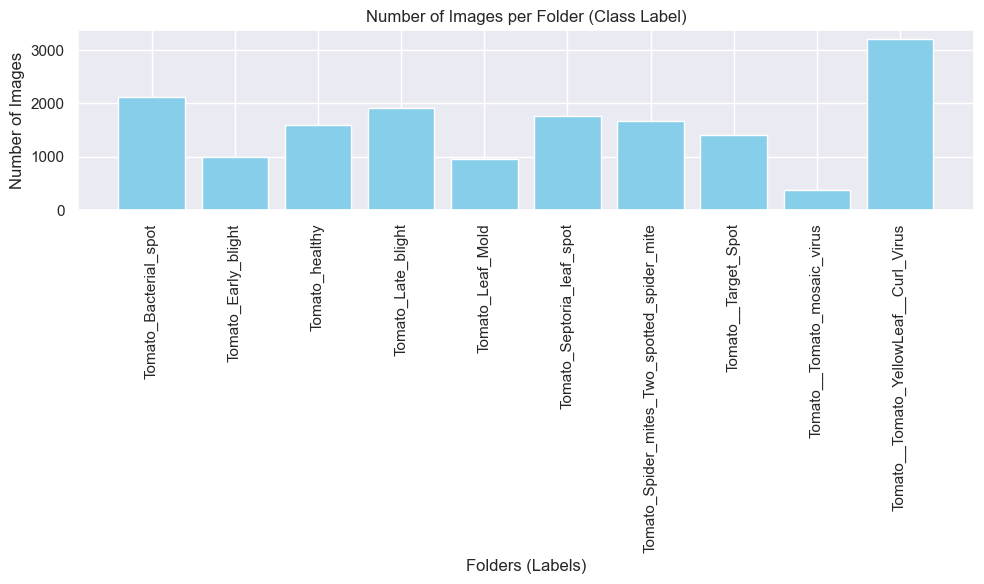

In [27]:
dataset_info(dataset_dir)

In [ ]:
# create new dataset using all the healthy Tomato leaf and randomly selecting 177 inages from each unhealthy category
# Once Dataset is created you don't need to run it again
# Paths for  the new dataset

new_dataset_dir = r'C:\Users\amani\ku_challenges\PlantVillage\new_dataset'

# Paths for new folders: Tomato_healthy and Tomato_unhealthy
healthy_dir = os.path.join(new_dataset_dir, 'Tomato_healthy')
unhealthy_dir = os.path.join(new_dataset_dir, 'Tomato_unhealthy')

# Create the new folders if they don't exist
os.makedirs(healthy_dir, exist_ok=True)
os.makedirs(unhealthy_dir, exist_ok=True)

# Copy all images from Tomato_healthy folder
tomato_healthy_src = os.path.join(dataset_dir, 'Tomato_healthy')
if os.path.exists(tomato_healthy_src):
    for image in os.listdir(tomato_healthy_src):
        if image.endswith(('.jpg', '.JPG')):
            shutil.copy(os.path.join(tomato_healthy_src, image), healthy_dir)

# Randomly select 177 images from other disease folders and copy to Tomato_unhealthy
disease_folders = [folder for folder in os.listdir(dataset_dir) 
                   if folder != 'Tomato_healthy' and os.path.isdir(os.path.join(dataset_dir, folder))]

unhealthy_images = []

# Loop through disease folders to collect images
for folder in disease_folders:
    folder_path = os.path.join(dataset_dir, folder)
    images = [img for img in os.listdir(folder_path) if img.endswith(('.jpg', '.JPG'))]

    # Shuffle the images and select 177 from each folder
    random.shuffle(images)
    selected_images = images[:177]

    # Copy the selected images to the Tomato_unhealthy folder
    for image in selected_images:
        src_path = os.path.join(folder_path, image)
        shutil.copy(src_path, unhealthy_dir)

# Display the count of images in both folders
healthy_count = len(os.listdir(healthy_dir))
unhealthy_count = len(os.listdir(unhealthy_dir))

print(f"[INFO] {healthy_count} images copied to Tomato_healthy")
print(f"[INFO] {unhealthy_count} images copied to Tomato_unhealthy")


[INFO] 1591 images copied to Tomato_healthy
[INFO] 1593 images copied to Tomato_unhealthy


[INFO] Image loading completed
Folder: Tomato_healthy, Number of images: 1591


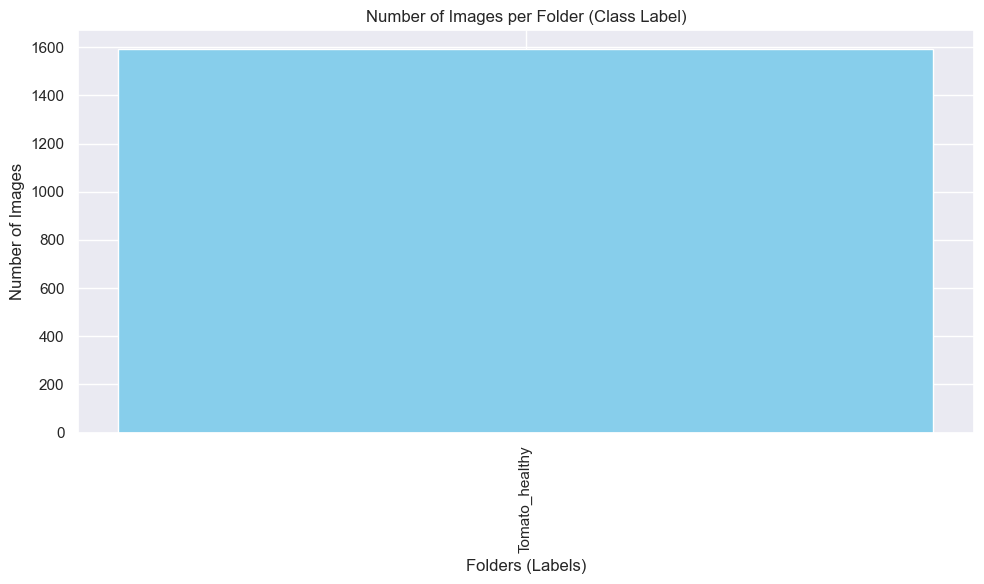

In [29]:
dataset_info(new_dataset_dir)

In [30]:
# Function to convert Images into array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [32]:
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(new_dataset_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{new_dataset_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:]:
            image_directory = f"{new_dataset_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_unhealthy ...
[INFO] Image loading completed

Total number of images: 3184


In [39]:
# Save binary labels to pickle file

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  2


In [40]:
for classification in label_binarizer.classes_:
    print(classification)

Tomato_healthy
Tomato_unhealthy


In [41]:
np_image_list.shape

(3184, 256, 256, 3)

# Augment and Split Dataset

In [43]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

In [44]:
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 1) 

[INFO] Splitting data to train and test...


In [59]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(2547, 256, 256, 3)
(637, 256, 256, 3)
(2547, 1)
(637, 1)


In [61]:
# Prepare the model layers
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape = (256,256,3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

In [63]:
# Train the model
model.fit(x_train,y_train,epochs=25,batch_size=64)

Epoch 1/25
40/40 [==============================] - 17s 398ms/step - loss: 1.1174 - accuracy: 0.5905
Epoch 2/25
40/40 [==============================] - 16s 403ms/step - loss: 0.2200 - accuracy: 0.9117
Epoch 3/25
40/40 [==============================] - 16s 397ms/step - loss: 0.1331 - accuracy: 0.9513
Epoch 4/25
40/40 [==============================] - 18s 445ms/step - loss: 0.1020 - accuracy: 0.9662
Epoch 5/25
40/40 [==============================] - 18s 453ms/step - loss: 0.0625 - accuracy: 0.9776
Epoch 6/25
40/40 [==============================] - 18s 449ms/step - loss: 0.0405 - accuracy: 0.9882
Epoch 7/25
40/40 [==============================] - 18s 458ms/step - loss: 0.0232 - accuracy: 0.9929
Epoch 8/25
40/40 [==============================] - 18s 453ms/step - loss: 0.0131 - accuracy: 0.9976
Epoch 9/25
40/40 [==============================] - 18s 454ms/step - loss: 0.0093 - accuracy: 0.9980
Epoch 10/25
40/40 [==============================] - 18s 450ms/step - loss: 0.0078 - accura

In [64]:
model.evaluate(x_test,y_test)

20/20 [==============================] - 2s 94ms/step - loss: 0.0861 - accuracy: 0.9780


[0.08607692271471024, 0.9780219793319702]

In [62]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])